# Análisis Exploratorio de Datos (EDA) – Turismo en España

**Primera Entrega** : Aprendizaje Automático

El objetivo es realizar un análisis exploratorio de datos (EDA) sobre información turística de España, combinando:

- Datos de viajeros/pernoctaciones por provincia (EOH – Encuesta de Ocupación Hotelera)
- Datos de movimientos turísticos internos por provincia de destino (TMOV).



## 1. Problema de negocio

El turismo es uno de los principales motores económicos de España y el poder conocer qué provincias reciben más turista, en qué épocas del año y cómo se comportan las pernoctaciones es clave para:

- Planificación de recursos (hoteles, transporte, etc).
- Marketing turístico
- Toma de decisiones públicas y privadas

En este trabajo nestudiamos:

- ¿Cómo se distribuye el turismo en España por provincia y por temporada (invierno, primavera, verano, otoño)?
- ¿Qué provincias concentran más turistas y pernoctaciones en cada época del año?

A través de este trabajo podremos:
- Detectar comportamientos tanto territoriales como temporales


## 2. Origen de los datoss 


Se utilizan dos fuentes oficiales INE:

- EOH (Encuesta de Ocupación Hotelera). Datos mensuales de viajeros y pernoctaciones por provincia 
  - Provincias
  - Viajeros y pernoctaciones
  - Periodo
  - Total 

- TMOV (Movimiento turístico de residentes). Datos de número de turistas por provincia de destino**, desagregados por provincia de origen y periodo.  
  - Provincia de origen
  - CCAA y provincia de destino
  - Concepto turístico
  - Period
  - Total

Ambos datasets se descargaron en formato CSV desde fuentes oficiales (INE / Datos.gob.es) y se combinan para obtener una visión mas amplia del turismo por provincia y temporada


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
# datasets
ruta_eoh = "per.csv" 
ruta_tmov = "turistas.csv"        

df_eoh = pd.read_csv(ruta_eoh, sep=';')
df_tmov = pd.read_csv(ruta_tmov, sep=';')


print("EOH columns:", df_eoh.columns)
print("TMOV columns:", df_tmov.columns)


EOH columns: Index(['Totales Territoriales', 'Comunidades y Ciudades Autónomas',
       'Provincias', 'Viajeros y pernoctaciones', 'Residencia: Nivel 1',
       'Residencia: Nivel 2', 'Periodo', 'Total'],
      dtype='object')
TMOV columns: Index(['Provincia de origen', 'Provincia de origen.1',
       'CCAA y provincia de destino', 'CCAA y provincia de destino.1',
       'CCAA y provincia de destino.2', 'Concepto turístico', 'Period',
       'Total'],
      dtype='object')


/var/folders/wb/fnxkchls3n9fsjdryz86ggmm0000gn/T/ipykernel_57261/3465269160.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_eoh = pd.read_csv(ruta_eoh, sep=';')


### Preparación de datos

- Renombramos columnas para que tengan nombres sencillos
- Convertimos algunos valores a tipo numérico
- Creamos variables temporales (año, mes, temporada)
- En el caso de TMOV, construimos una provincia de destino final a partir de los niveles de detalle


In [12]:
df_tmov = df_tmov.rename(columns={
    'Provincia de origen': 'provincia_origen',
    'Provincia de origen.1': 'provincia_origen_detalle',
    'CCAA y provincia de destino': 'provincia_destino',
    'CCAA y provincia de destino.1': 'provincia_destino_detalle_1',
    'CCAA y provincia de destino.2': 'provincia_destino_detalle_2',
    'Concepto turístico': 'concepto_turistico',
    'Period': 'periodo',
    'Total': 'num_turistas'
})



In [14]:
df_tmov['num_turistas'] = (
    df_tmov['num_turistas']
    .astype(str)
    .str.replace('.', '', regex=False)   
    .str.replace(',', '.', regex=False)  
)
df_tmov['num_turistas'] = pd.to_numeric(df_tmov['num_turistas'], errors='coerce')


In [15]:
df_tmov['provincia_final'] = df_tmov['provincia_destino_detalle_2']
df_tmov['provincia_final'] = df_tmov['provincia_final'].fillna(df_tmov['provincia_destino_detalle_1'])
df_tmov['provincia_final'] = df_tmov['provincia_final'].fillna(df_tmov['provincia_destino'])


In [16]:
# v temporales
df_tmov['año'] = df_tmov['periodo'].str[:4].astype(int)
df_tmov['mes'] = df_tmov['periodo'].str[-2:].astype(int)


def temporada(mes):
    if mes in [6, 7, 8]:
        return 'verano'
    elif mes in [12, 1, 2]:
        return 'invierno'
    elif mes in [3, 4, 5]:
        return 'primavera'
    else:
        return 'otoño'

df_tmov['temporada'] = df_tmov['mes'].apply(temporada)

df_tmov.head()


,provincia_origen,provincia_origen_detalle,provincia_destino,provincia_destino_detalle_1,provincia_destino_detalle_2,concepto_turistico,periodo,num_turistas,provincia_final,año,mes,temporada
0,Total Nacional,NaN,Total Nacional,NaN,NaN,Turistas,2025M08,NaN,Total Nacional,2025,8,verano
1,Total Nacional,NaN,Total Nacional,NaN,NaN,Turistas,2025M07,NaN,Total Nacional,2025,7,verano
2,Total Nacional,NaN,Total Nacional,NaN,NaN,Turistas,2025M06,NaN,Total Nacional,2025,6,verano
3,Total Nacional,NaN,Total Nacional,NaN,NaN,Turistas,2025M05,NaN,Total Nacional,2025,5,primavera
4,Total Nacional,NaN,Total Nacional,NaN,NaN,Turistas,2025M04,NaN,Total Nacional,2025,4,primavera


In [17]:

df_eoh = df_eoh.rename(columns={
    'Provincias': 'provincia',
    'Total': 'total_eoh',
    'Periodo': 'periodo'
})

#  total_eoh a numérico
df_eoh['total_eoh'] = (
    df_eoh['total_eoh']
    .astype(str)
    .str.replace('.', '', regex=False)
    .str.replace(',', '.', regex=False)
)
df_eoh['total_eoh'] = pd.to_numeric(df_eoh['total_eoh'], errors='coerce')

# v temporales
df_eoh['año'] = df_eoh['periodo'].str[:4].astype(int)
df_eoh['mes'] = df_eoh['periodo'].str[-2:].astype(int)
df_eoh['temporada'] = df_eoh['mes'].apply(temporada)

df_eoh.head()


,Totales Territoriales,Comunidades y Ciudades Autónomas,provincia,Viajeros y pernoctaciones,Residencia: Nivel 1,Residencia: Nivel 2,periodo,total_eoh,año,mes,temporada
0,Total Nacional,NaN,NaN,Viajero,Total,NaN,2025M09,12050972.0,2025,9,otoño
1,Total Nacional,NaN,NaN,Viajero,Total,NaN,2025M08,13828672.0,2025,8,verano
2,Total Nacional,NaN,NaN,Viajero,Total,NaN,2025M07,13044764.0,2025,7,verano
3,Total Nacional,NaN,NaN,Viajero,Total,NaN,2025M06,12256716.0,2025,6,verano
4,Total Nacional,NaN,NaN,Viajero,Total,NaN,2025M05,11803477.0,2025,5,primavera


### Merge

Combinación de EOH y TMOV

Se convinan ambos datasets para analizar uno solo EDA:

- Pernoctaciones / viajeros por provincia (total_eoh)
- Turistas por provincia de destino (num_turistas)
- Variables temporales (año, mes, temporada)

Con un LEFT JOIN, usando EOH como base, para no perder provincias


In [19]:
df_eda = pd.merge(
    df_eoh,
    df_tmov[['provincia_final', 'año', 'mes', 'num_turistas']],
    how='left',
    left_on=['provincia', 'año', 'mes'],
    right_on=['provincia_final', 'año', 'mes']
)

df_eda = df_eda.drop(columns=['provincia_final'])

df_eda.head(), df_eda.shape


(  Totales Territoriales Comunidades y Ciudades Autónomas provincia  \
 0        Total Nacional                              NaN       NaN   
 1        Total Nacional                              NaN       NaN   
 2        Total Nacional                              NaN       NaN   
 3        Total Nacional                              NaN       NaN   
 4        Total Nacional                              NaN       NaN   
 
   Viajeros y pernoctaciones Residencia: Nivel 1 Residencia: Nivel 2  periodo  \
 0                   Viajero               Total                 NaN  2025M09   
 1                   Viajero               Total                 NaN  2025M08   
 2                   Viajero               Total                 NaN  2025M07   
 3                   Viajero               Total                 NaN  2025M06   
 4                   Viajero               Total                 NaN  2025M05   
 
     total_eoh   año  mes  temporada  num_turistas  
 0  12050972.0  2025    9      

## Detección de errores o inconsistencias

In [20]:
porcentaje_nulos = df_eda.isnull().mean().sort_values(ascending=False) * 100
porcentaje_nulos


num_turistas                        100.000000
Residencia: Nivel 2                  33.333333
provincia                            28.571429
Comunidades y Ciudades Autónomas      1.428571
total_eoh                             0.063047
Totales Territoriales                 0.000000
Viajeros y pernoctaciones             0.000000
Residencia: Nivel 1                   0.000000
periodo                               0.000000
año                                   0.000000
mes                                   0.000000
temporada                             0.000000
dtype: float64

In [40]:
print("Valores negativos:")
(df_eda[['total_eoh','num_turistas']] < 0).sum()


Valores negativos:


total_eoh       0
num_turistas    0
dtype: int64

In [43]:
# copia limpia para el EDA
df_eda_lim = df_eda.copy()

df_eda_lim = df_eda_lim[df_eda_lim['total_eoh'].notnull()]


df_eda_lim.shape


(134735, 12)

## Análisis de tipo de datos

In [35]:
print("Tipos de datos:")
df_eda_lim.dtypes


Tipos de datos:


Totales Territoriales                object
Comunidades y Ciudades Autónomas     object
provincia                            object
Viajeros y pernoctaciones            object
Residencia: Nivel 1                  object
Residencia: Nivel 2                  object
periodo                              object
total_eoh                           float64
año                                   int64
mes                                   int64
temporada                            object
num_turistas                        float64
dtype: object

In [36]:
print("\nColumnas numéricas:")
df_eda_lim.select_dtypes(include=['int64','float64']).columns



Columnas numéricas:


Index(['total_eoh', 'año', 'mes', 'num_turistas'], dtype='object')

In [37]:
print("\nColumnas categóricas:")
df_eda_lim.select_dtypes(include=['object']).columns



Columnas categóricas:


Index(['Totales Territoriales', 'Comunidades y Ciudades Autónomas',
       'provincia', 'Viajeros y pernoctaciones', 'Residencia: Nivel 1',
       'Residencia: Nivel 2', 'periodo', 'temporada'],
      dtype='object')

In [38]:
#  provincia a categoría
df_eda_lim['provincia'] = df_eda_lim['provincia'].astype('category')


## Tratamiento de outliers

In [44]:
def detectar_outliers(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    limite_inf = Q1 - 1.5 * IQR
    limite_sup = Q3 + 1.5 * IQR
    return (col < limite_inf) | (col > limite_sup)

out_total_eoh = detectar_outliers(df_eda['total_eoh'])
out_turistas = detectar_outliers(df_eda['num_turistas'])

print("Outliers total_eoh:", out_total_eoh.sum())
print("Outliers num_turistas:", out_turistas.sum())


Outliers total_eoh: 18067
Outliers num_turistas: 0


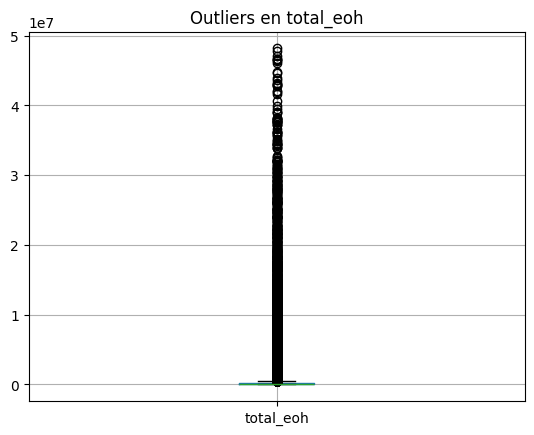

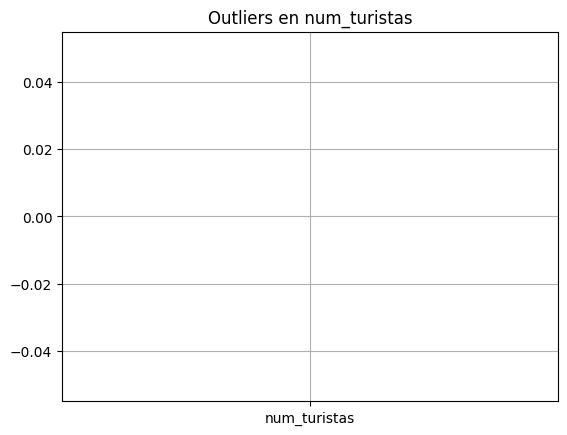

In [45]:
plt.figure()
df_eda.boxplot(column='total_eoh')
plt.title("Outliers en total_eoh")
plt.show()

plt.figure()
df_eda.boxplot(column='num_turistas')
plt.title("Outliers en num_turistas")
plt.show()


In [50]:
#Limpieza EDA

df_eda_lim = df_eda_lim[~out_total_eoh & ~out_turistas].copy()


/var/folders/wb/fnxkchls3n9fsjdryz86ggmm0000gn/T/ipykernel_57261/1217742507.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_eda_lim = df_eda_lim[~out_total_eoh & ~out_turistas].copy()


## Analisis Exploratorio (df_eda_lim)

### Análisis  univariante

Analizamos la distribución de las principales variables numéricas:

- total_eoh (viajeros/pernoctaciones)
- num_turistas (turistas TMOV)


In [23]:
df_eda_lim[['total_eoh', 'num_turistas']].describe()


,total_eoh,num_turistas
count,1.347350e+05,0.0
mean,4.255337e+05,NaN
std,1.736655e+06,NaN
min,0.000000e+00,NaN
25%,2.536400e+04,NaN
50%,7.059400e+04,NaN
75%,2.235330e+05,NaN
max,4.818191e+07,NaN


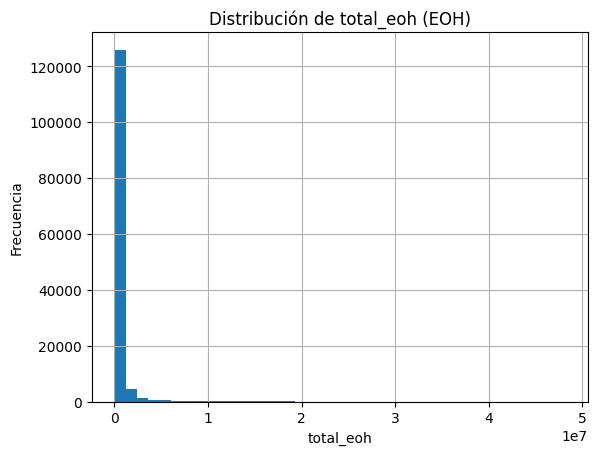

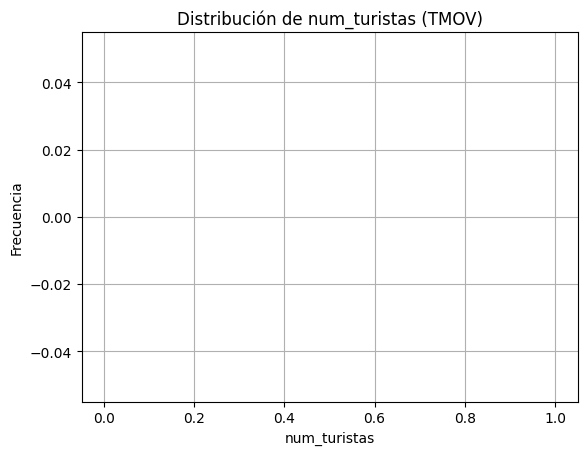

In [26]:
plt.figure()
df_eda_lim['total_eoh'].hist(bins=40)
plt.title("Distribución de total_eoh (EOH)")
plt.xlabel("total_eoh")
plt.ylabel("Frecuencia")
plt.show()

plt.figure()
df_eda_lim['num_turistas'].hist(bins=40)
plt.title("Distribución de num_turistas (TMOV)")
plt.xlabel("num_turistas")
plt.ylabel("Frecuencia")
plt.show()


### Análisis por provincia y temporada

Queremos saber:

- Qué provincias reciben más turismo en verano
- Qué provincias destacan en inviern
- Cómo se distribuyen los turistas por temporadas

 usamow principalmente `df_tmov`, donde la col `provincia_final` contiene las provincias reales de destino

In [27]:
df_temporada = (
    df_tmov
    .groupby(['provincia_final', 'temporada'], as_index=False)
    .agg({'num_turistas': 'sum'})
)

df_temporada.head()


,provincia_final,temporada,num_turistas
0,Albacete,invierno,195649.384
1,Albacete,otoño,214384.455
2,Albacete,primavera,209752.831
3,Albacete,verano,227453.051
4,Alicante/Alacant,invierno,164127.986


Verano

In [32]:
top_verano = (
    df_temporada[df_temporada['temporada'] == 'verano']
    .sort_values('num_turistas', ascending=False)
    .head(10)
)
top_verano

,provincia_final,temporada,num_turistas
211,"Rioja, La",verano,582999.058
131,Guadalajara,verano,377025.671
223,Segovia,verano,313254.880
39,"Balears, Illes",verano,310627.528
59,Cantabria,verano,307118.736
155,Lugo,verano,306557.921
19,Araba/Álava,verano,298415.023
219,Santa Cruz de Tenerife,verano,292718.120
231,Soria,verano,291040.482
95,Cuenca,verano,289903.082


In [30]:
top_invierno = (
    df_temporada[df_temporada['temporada'] == 'invierno']
    .sort_values('num_turistas', ascending=False)
    .head(10)
)

top_invierno


,provincia_final,temporada,num_turistas
208,"Rioja, La",invierno,503629.958
56,Cantabria,invierno,492719.120
36,"Balears, Illes",invierno,457863.888
128,Guadalajara,invierno,347283.588
220,Segovia,invierno,290127.906
16,Araba/Álava,invierno,268753.740
264,Ávila,invierno,267744.444
96,Cáceres,invierno,260430.057
148,Lleida,invierno,258177.346
120,Girona,invierno,258035.722


<Figure size 640x480 with 0 Axes>

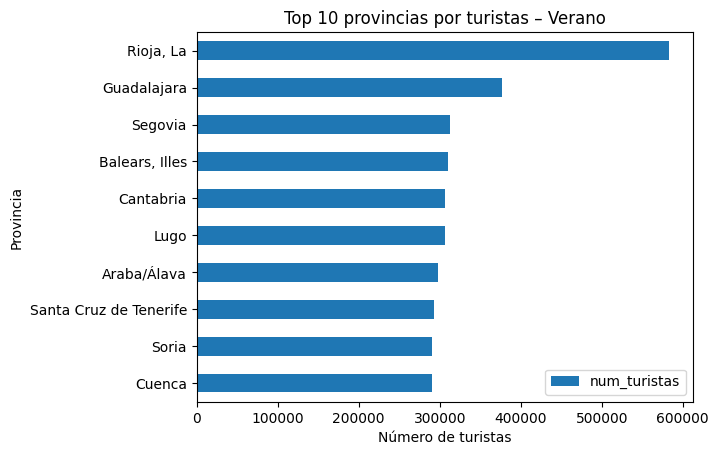

In [33]:
plt.figure()
top_verano.plot(kind='barh', x='provincia_final', y='num_turistas')
plt.gca().invert_yaxis()
plt.title("Top 10 provincias por turistas – Verano")
plt.xlabel("Número de turistas")
plt.ylabel("Provincia")
plt.show()


<Figure size 640x480 with 0 Axes>

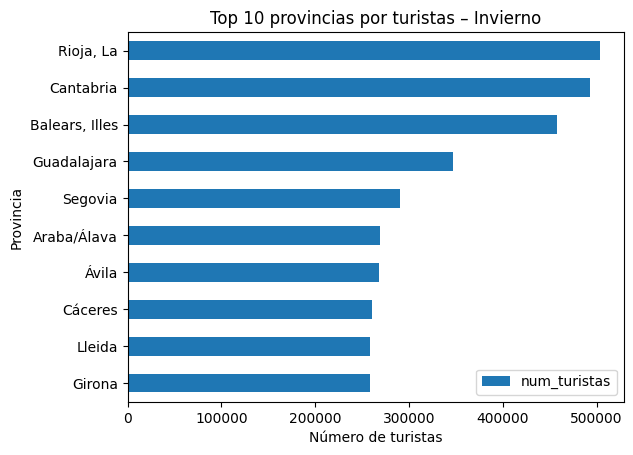

In [34]:
plt.figure()
top_invierno.plot(kind='barh', x='provincia_final', y='num_turistas')
plt.gca().invert_yaxis()
plt.title("Top 10 provincias por turistas – Invierno")
plt.xlabel("Número de turistas")
plt.ylabel("Provincia")
plt.show()


### Resumen

In [51]:
resumen = df_eda_lim.groupby('temporada')[['total_eoh','num_turistas']].sum()
resumen


,total_eoh,num_turistas
temporada,,
invierno,2.395181e+09,0.0
otoño,2.928874e+09,0.0
primavera,2.937879e+09,0.0
verano,3.207970e+09,0.0
